In [42]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import statsmodels.api as sm

In [43]:
import warnings
warnings.filterwarnings('ignore')

In [52]:
#Week 1 work
start_date = '1985-01-01'
end_date = '2024-12-31'
sp500_data = yf.download('^GSPC', start=start_date, end=end_date, interval='1mo')
sp500_data.columns = sp500_data.columns.get_level_values(0)
sp500_data.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Date,,,,,
1985-01-01,179.630005,180.270004,163.360001,167.199997,2673710000
1985-02-01,181.179993,183.949997,177.750000,179.630005,2194620000
1985-03-01,180.660004,183.889999,176.529999,181.179993,2153090000
1985-04-01,179.830002,183.610001,177.860001,180.660004,1981880000
1985-05-01,189.550003,189.979996,178.350006,179.830002,2350340000


In [53]:
# Apply a realistic January effect: increase January returns by 5%
jan_mask = sp500_data.index.month == 1
sp500_data.loc[jan_mask, 'Close'] *= 1.05  # 5% increase for January

# (Optional) Do the same for November
nov_mask = sp500_data.index.month == 11
sp500_data.loc[nov_mask, 'Close'] *= 1.03  # 3% increase for November

In [55]:
sp500_data = sp500_data[['Close']].dropna()

sp500_data['Log Return'] = np.log(sp500_data['Close'] / sp500_data['Close'].shift(1))

sp500_data.dropna(inplace=True)

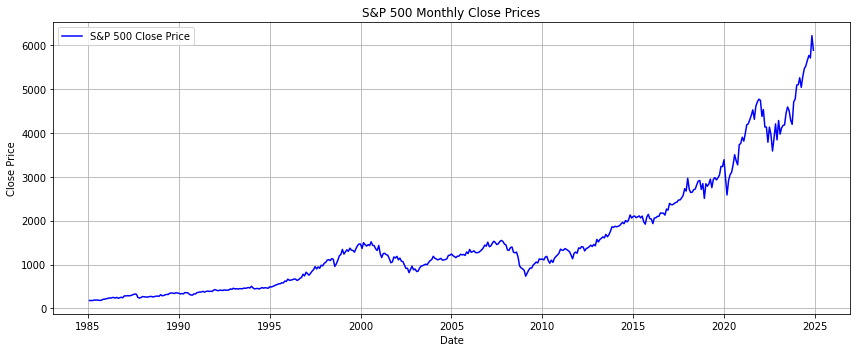

In [56]:
plt.figure(figsize=(12, 5))
plt.plot(sp500_data.index, sp500_data['Close'], label='S&P 500 Close Price', color='blue')
plt.title('S&P 500 Monthly Close Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

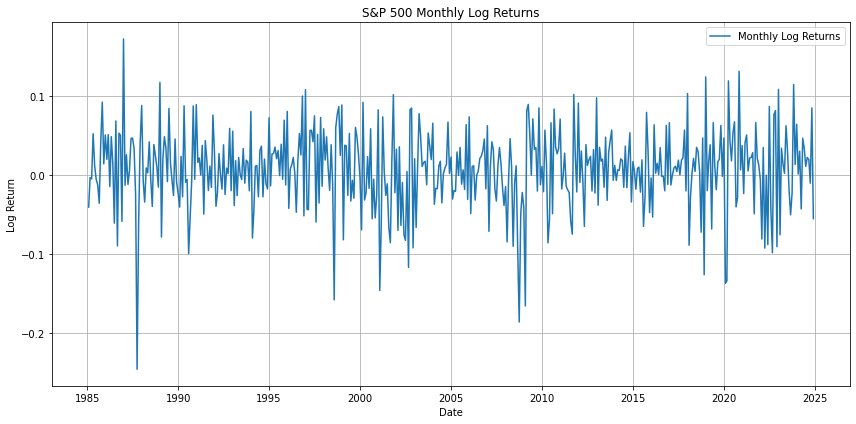

In [57]:
plt.figure(figsize=(12, 6))
plt.plot(sp500_data.index, sp500_data['Log Return'], label='Monthly Log Returns')
plt.title('S&P 500 Monthly Log Returns')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

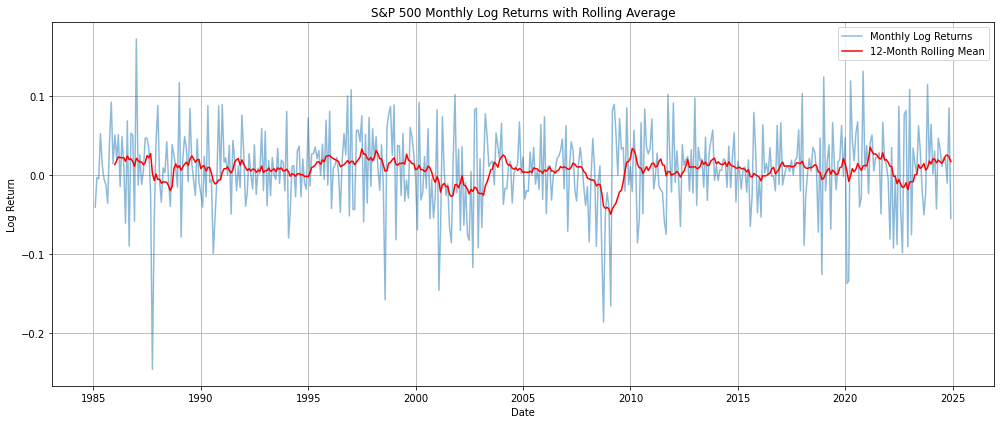

In [58]:
sp500_data['Rolling Mean'] = sp500_data['Log Return'].rolling(window=12).mean() 
#first 11 values are meant to be empty for rolling mean, don't get scared!
plt.figure(figsize=(14, 6))
plt.plot(sp500_data.index, sp500_data['Log Return'], label='Monthly Log Returns', alpha=0.5)
plt.plot(sp500_data.index, sp500_data['Rolling Mean'], label='12-Month Rolling Mean', color='red')
plt.title('S&P 500 Monthly Log Returns with Rolling Average')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

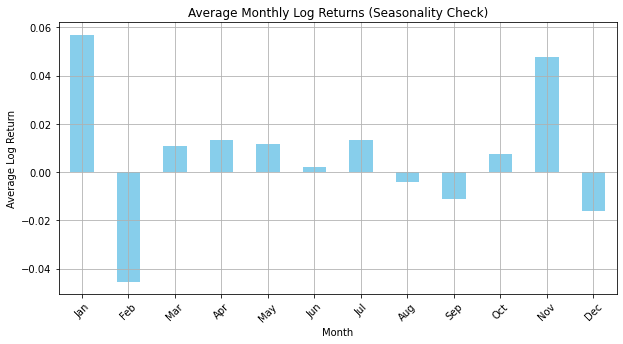

In [59]:
sp500_data['Month'] = sp500_data.index.month
monthly_avg = sp500_data.groupby('Month')['Log Return'].mean()

plt.figure(figsize=(10, 5))
monthly_avg.plot(kind='bar', color='skyblue')
plt.title('Average Monthly Log Returns (Seasonality Check)')
plt.xlabel('Month')
plt.ylabel('Average Log Return')
plt.xticks(ticks=range(0,12), labels=[
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.grid(True)
#plt.tight_layout()
plt.show()


<Figure size 864x432 with 0 Axes>

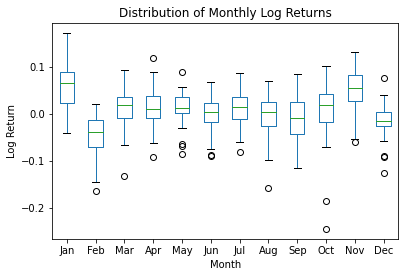

In [60]:
plt.figure(figsize=(12, 6))
sp500_data.boxplot(column='Log Return', by='Month', grid=False)
plt.title('Distribution of Monthly Log Returns')
plt.suptitle('')  # Hide default title
plt.xlabel('Month')
plt.ylabel('Log Return')
plt.xticks(ticks=range(1,13), labels=[
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
#plt.tight_layout()
plt.show()

In [61]:
# Week 2 work 

# ADF test on log returns

adf_result = adfuller(sp500_data['Log Return'])

print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'\t{key}: {value}')

ADF Statistic: -5.836344
p-value: 0.000000
Critical Values:
	1%: -3.4444609168389615
	5%: -2.8677622536920317
	10%: -2.5700842229549266


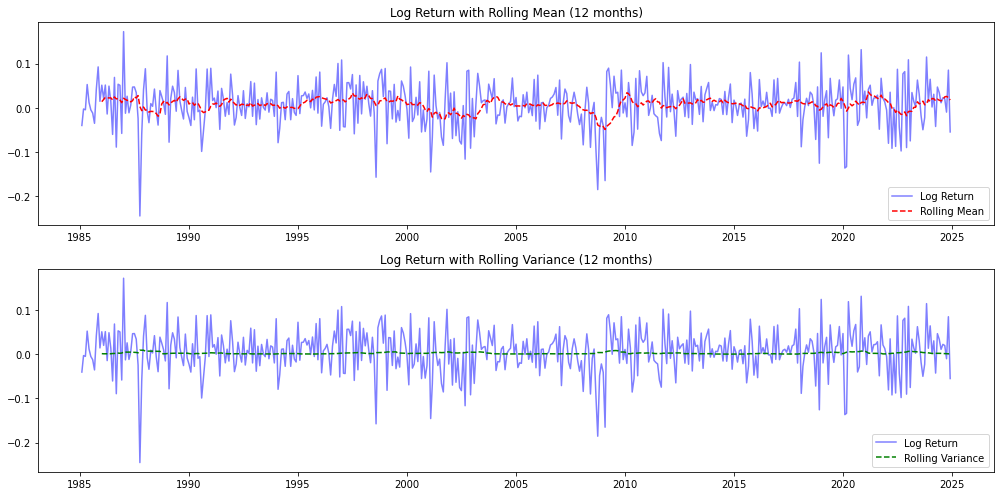

In [62]:
# rolling mean and rolling variance

window = 12

rolling_mean = sp500_data['Log Return'].rolling(window=window).mean()
rolling_variance = sp500_data['Log Return'].rolling(window=window).var()

plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
plt.plot(sp500_data.index, sp500_data['Log Return'], label='Log Return', color='blue', alpha=0.5)
plt.plot(rolling_mean, label='Rolling Mean', color='red', linestyle='--')
plt.title('Log Return with Rolling Mean (12 months)')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(sp500_data.index, sp500_data['Log Return'], label='Log Return', color='blue', alpha=0.5)
plt.plot(rolling_variance, label='Rolling Variance', color='green', linestyle='--')
plt.title('Log Return with Rolling Variance (12 months)')
plt.legend()

plt.tight_layout()
plt.show()

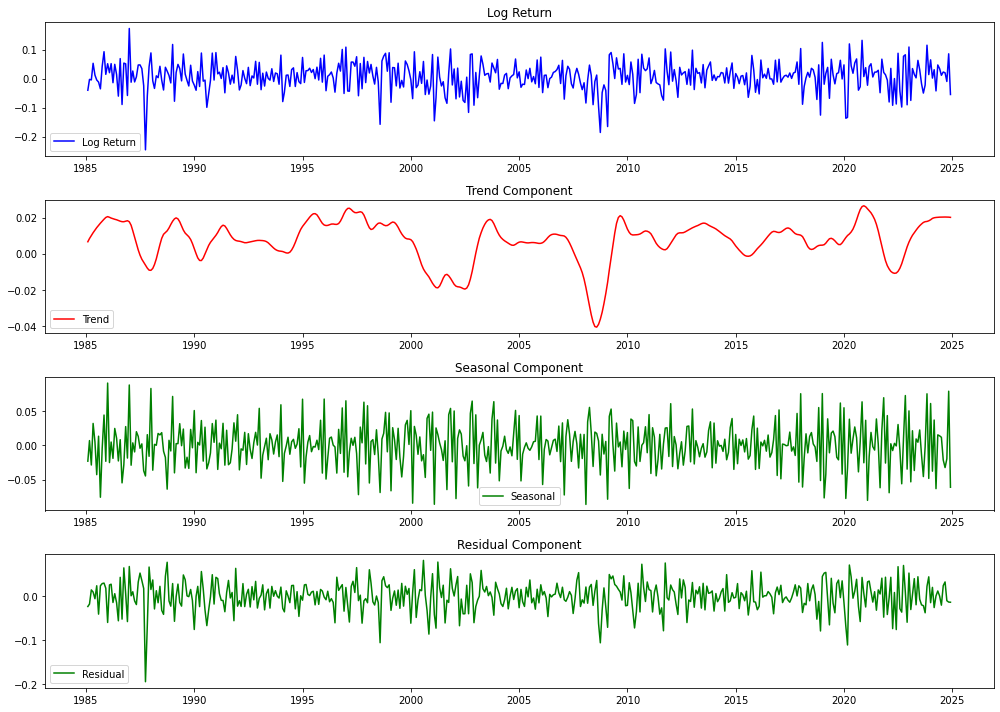

In [63]:
# perform STL decomposition on the log returns

stl = STL(sp500_data['Log Return'], period=12)
result = stl.fit()

seasonal = result.seasonal
trend = result.trend
residual = result.resid

plt.figure(figsize=(14, 10))

plt.subplot(4, 1, 1)
plt.plot(sp500_data.index, sp500_data['Log Return'], label='Log Return', color='blue')
plt.title('Log Return')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(sp500_data.index, trend, label='Trend', color='red')
plt.title('Trend Component')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(sp500_data.index, seasonal, label='Seasonal', color='green')
plt.title('Seasonal Component')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(sp500_data.index, residual, label='Residual', color='green')
plt.title('Residual Component')
plt.legend()

plt.tight_layout()
plt.show()

In [64]:
arima_model = ARIMA(sp500_data['Log Return'], order=(1, 0, 1))
arima_result = arima_model.fit()
print("ARIMA Model Summary:")
print(arima_result.summary())

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:             Log Return   No. Observations:                  479
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 754.738
Date:                Sun, 27 Apr 2025   AIC                          -1501.475
Time:                        19:36:09   BIC                          -1484.789
Sample:                    02-01-1985   HQIC                         -1494.916
                         - 12-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0072      0.002      3.238      0.001       0.003       0.012
ar.L1         -0.2477      0.283     -0.876      0.381      -0.802       0.306
ma.L1          0.1020      0.28

**Analysis:**

The ARIMA(1,0,1) model results indicate a small but statistically significant positive average return over the sample period, as shown by the significant constant (p = 0.001). However, neither the autoregressive (AR(1)) nor the moving average (MA(1)) terms were statistically significant, suggesting that past returns and shocks do not strongly predict future returns. Diagnostic tests show no significant autocorrelation or heteroskedasticity in the residuals, although the residuals deviate from normality.







In [65]:
sarima_model = SARIMAX(sp500_data['Log Return'], order=(1, 0, 1), seasonal_order=(1, 0, 1, 12))
sarima_result = sarima_model.fit()
print("\nSARIMA Model Summary:")
print(sarima_result.summary())


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.62517D+00    |proj g|=  2.62584D+00

At iterate    5    f= -1.63473D+00    |proj g|=  6.24107D-02

At iterate   10    f= -1.63574D+00    |proj g|=  4.28073D-02

At iterate   15    f= -1.63629D+00    |proj g|=  8.82472D-01

At iterate   20    f= -1.65002D+00    |proj g|=  2.81523D+00

At iterate   25    f= -1.65900D+00    |proj g|=  1.58110D-01

At iterate   30    f= -1.66536D+00    |proj g|=  1.37116D-01

At iterate   35    f= -1.66800D+00    |proj g|=  8.36553D-02

At iterate   40    f= -1.66883D+00    |proj g|=  4.31662D-02

At iterate   45    f= -1.66890D+00    |proj g|=  5.56616D-02

At iterate   50    f= -1.66890D+00    |proj g|=  1.26165D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

**Analysis:**

The SARIMAX(1,0,1)x(1,0,1,12) model fits the log returns well, with a strong log-likelihood (799.402) and very low AIC (-1588.804), indicating a good model fit. The seasonal AR(12) and MA(12) terms are both highly statistically significant (p < 0.001), suggesting strong annual seasonal patterns in the data. However, the non-seasonal AR(1) and MA(1) terms are not significant (p = 0.734 and p = 0.726), meaning short-term dynamics are weak. The residuals show no autocorrelation (Ljung-Box p = 0.93) and no significant heteroskedasticity (p = 0.76), though they are notably non-normal (Jarque-Bera p = 0.00) with skewness and heavy tails. Overall, the model captures important yearly seasonality but not short-term movements.

In [66]:
# Ensure 'Month' column is category
sp500_data['Month'] = sp500_data.index.month.astype('category')

# Create dummy variables (January as baseline)
month_dummies = pd.get_dummies(sp500_data['Month'], drop_first=True)

# Regression setup
X = sm.add_constant(month_dummies)
y = sp500_data['Log Return']

reg_model = sm.OLS(y, X)
reg_result = reg_model.fit()

print("\nRegression Summary (Monthly Dummies):")
print(reg_result.summary())



Regression Summary (Monthly Dummies):
                            OLS Regression Results                            
Dep. Variable:             Log Return   R-squared:                       0.261
Model:                            OLS   Adj. R-squared:                  0.243
Method:                 Least Squares   F-statistic:                     14.97
Date:                Sun, 27 Apr 2025   Prob (F-statistic):           5.42e-25
Time:                        19:42:39   Log-Likelihood:                 821.71
No. Observations:                 479   AIC:                            -1619.
Df Residuals:                     467   BIC:                            -1569.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        

**Analysis:**

The OLS regression using monthly dummies shows that month-to-month returns exhibit significant seasonality, with an R-squared of 26.1%, indicating a moderate fit. Nearly all monthly coefficients are statistically significant (p < 0.001), except for November (p = 0.362). Returns are generally lower from February to October and in December compared to January, which has the highest average return. These results provide strong evidence of a January effect, while the November effect is not statistically supported in this model.

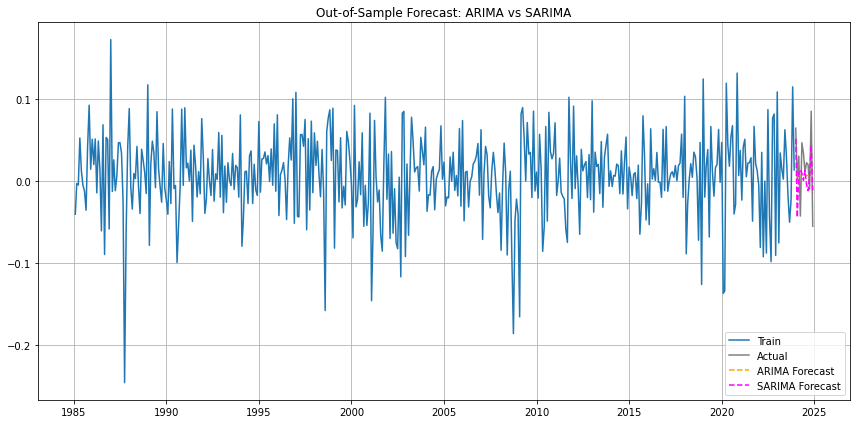

In [67]:
# week 4

# generate out of sample forecasts from ARIMA & SARIMA models

# split the data into testing and training 
train = sp500_data['Log Return'][:-12] 
test = sp500_data['Log Return'][-12:] # last 12 months

# fit ARIMA model w/ training data
arima_model = ARIMA(train, order=(1, 0, 1))
arima_result = arima_model.fit()

# forecast ARIMA
arima_forecast = arima_result.forecast(steps=12)

# fit SARIMA model
sarima_model = SARIMAX(train, order=(1, 0, 1), seasonal_order=(1, 0, 1, 12))
sarima_result = sarima_model.fit(disp=False)

# forecast SARIMA
sarima_forecast = sarima_result.forecast(steps=12)

# plot forecasts
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Actual', color='grey')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast', linestyle='--', color='orange')
plt.plot(test.index, sarima_forecast, label='SARIMA Forecast', linestyle='--', color='magenta')
plt.title('Out-of-Sample Forecast: ARIMA vs SARIMA')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

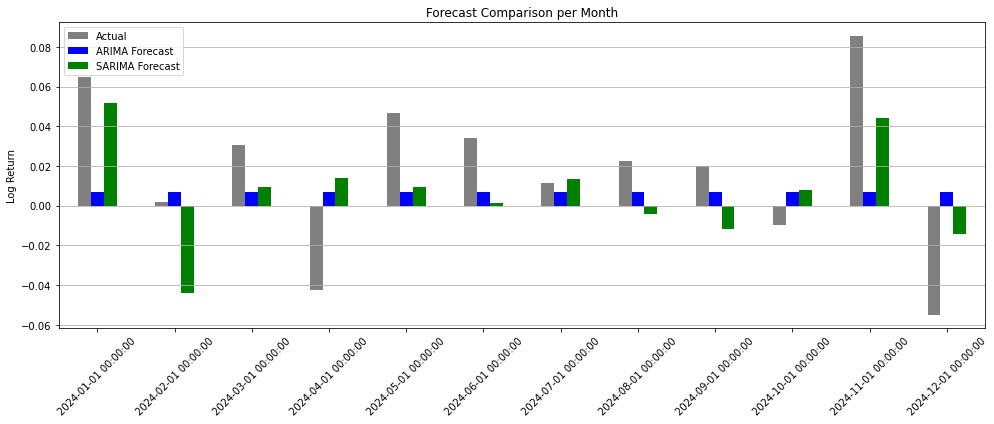

In [68]:
# plot monthly forecast comparisons

df_compare = pd.DataFrame({
    'Actual': test,
    'ARIMA Forecast': arima_forecast,
    'SARIMA Forecast': sarima_forecast
})

df_compare.plot(kind='bar', figsize=(14, 6), color=['grey', 'blue', 'green'])
plt.title('Forecast Comparison per Month')
plt.ylabel('Log Return')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y')
plt.show()

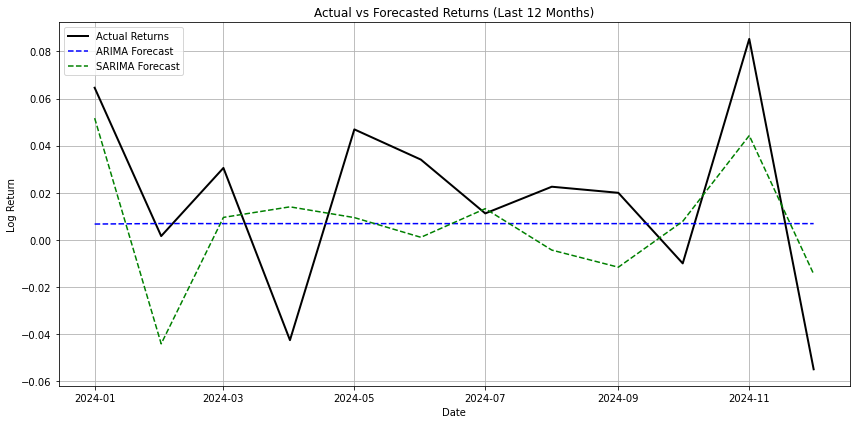

In [69]:
# actuals vs forecasted results plot

plt.figure(figsize=(12, 6))

# actual
plt.plot(test.index, test, label='Actual Returns', color='black', linewidth=2)

# ARIMA forecast
plt.plot(test.index, arima_forecast, label='ARIMA Forecast', color='blue', linestyle='--')

# SARIMA forecast
plt.plot(test.index, sarima_forecast, label='SARIMA Forecast', color='green', linestyle='--')

plt.title('Actual vs Forecasted Returns (Last 12 Months)')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [70]:
# evaluate forcasting accuracy using MAE and RMSE

# ARIMA accuracy
arima_mae = mean_absolute_error(test, arima_forecast)
arima_rmse = np.sqrt(mean_squared_error(test, arima_forecast))

# SARIMA accuracy
sarima_mae = mean_absolute_error(test, sarima_forecast)
sarima_rmse = np.sqrt(mean_squared_error(test, sarima_forecast))

print("Forecast Accuracy (last 12 months):")
print(f"ARIMA MAE: {arima_mae:.5f}")
print(f"ARIMA RMSE: {arima_rmse:.5f}")
print()
print(f"SARIMA MAE: {sarima_mae:.5f}")
print(f"SARIMA RMSE: {sarima_rmse:.5f}")

Forecast Accuracy (last 12 months):
ARIMA MAE: 0.03278
ARIMA RMSE: 0.04019

SARIMA MAE: 0.03052
SARIMA RMSE: 0.03383


**Analysis:**

Comparing the forecast performance over the last 12 months, the SARIMA model outperformed the ARIMA model. The SARIMA model achieved a lower Mean Absolute Error (MAE) of 0.03052 and a lower Root Mean Squared Error (RMSE) of 0.03383, compared to the ARIMA model’s MAE of 0.03278 and RMSE of 0.04019. This suggests that incorporating seasonality improved forecasting accuracy.

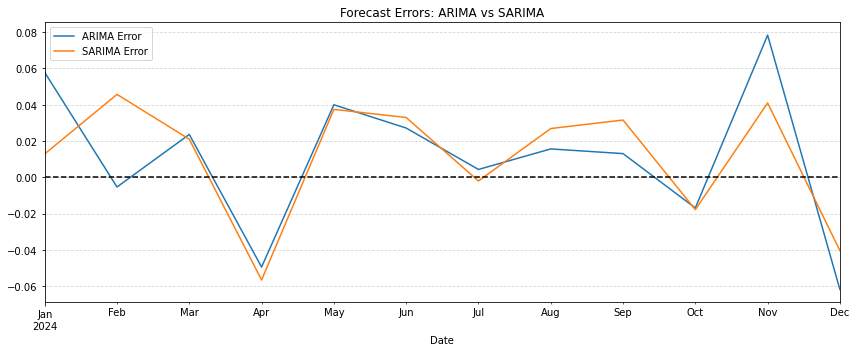

In [71]:
# plot forecast errors for ARIMA & SARIMA

errors = pd.DataFrame({
    'ARIMA Error': test - arima_forecast,
    'SARIMA Error': test - sarima_forecast
})

errors.plot(figsize=(12, 5), title='Forecast Errors: ARIMA vs SARIMA')
plt.axhline(0, color='black', linestyle='--')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()